[under construction. more comments and thought process needed]

# Introduction

Autobiographical memory, the recollection of personal experiences, has been a challenging area of study due to the inherent idiosyncrasy and subjectivity of individual memories.

This project addresses these challenges by focusing on a shared global experience: the COVID-19 pandemic. We collected narratives from participants across the globe, documenting their personal and collective experiences of the pandemic from 2020 to 2022. By focusing on a shared event, we aimed to reduce the idiosyncrasy inherent in autobiographical memory research, allowing for more robust comparisons between individuals and across time.

Furthermore, traditional methods often rely on qualitative analyses of interview data, which can be time-consuming and prone to researcher bias. Here, we innovatively employed computational natural language processing (NLP) techniques to analyze the collected narratives. This approach brought several advantages:


*   Objectivity: NLP methods provided an objective lens for analyzing the narratives, minimizing researcher bias.
*   Scalability: Computational tools allowed us to analyze a large volume of data efficiently, which would have been impossible with traditional qualitative methods.
*   Reproducibility: The use of standardized NLP techniques ensures the reproducibility of our findings, enhancing the rigor of the study.
*   Efficiency: NLP methods significantly accelerated the analysis process, enabling us to gain insights more quickly.

By combining a shared global experience with computational NLP techniques, this project provides a novel and rigorous approach to studying autobiographical memory, opening new avenues for understanding how individuals remember and make sense of significant life events.

# Preparation

## Import packages

In [3]:
#### Load in data ####
# read cleaned PPT
from google.colab import files
uploaded = files.upload()
# for the code to work, input two files: PPT_cleaned_final.xlsx, and ECDC_07072022.xlsx

Saving ECDC_07072022.xlsx to ECDC_07072022.xlsx


In [4]:
uploaded = files.upload()

Saving PPT_cleaned_final.xlsx to PPT_cleaned_final.xlsx


In [5]:
#### Load in packages ####
# data management packages
import numpy as np
import pandas as pd
# date packages
from datetime import datetime
# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
# NLP packages
import re
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
# USE packages
import tensorflow_hub as hub
USE = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# tSNE packages
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [6]:
#### Load in rpy2 to use R in .ipynb ####
# if there's any errors with rpy2, disconnect and reconnect runtime
import rpy2
from rpy2.robjects.pandas2ri import py2rpy, rpy2py
rpy2.robjects.pandas2ri.activate()
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages

pandas2ri.activate()

In [79]:
# uncomment the lines below to install packages in rpy2
# utils = rpackages.importr('utils')
# utils.chooseCRANmirror(ind=1)
# utils.install_packages('tidyverse')
# utils.install_packages('lme4')
# utils.install_packages('lmerTest')
# utils.install_packages('emmeans')
# utils.install_packages('boot')
# utils.install_packages('stm')
# utils.install_packages('tm')
# utils.install_packages('readxl')
# utils.install_packages('ggiraphExtra')
# utils.install_packages('igraph')
# utils.install_packages('huge')

In [8]:
%load_ext rpy2.ipython

In [80]:
# %%R
# library(tidyverse)
# library(lme4)
# library(lmerTest)
# library(emmeans)
# library(boot)
# library(stm)
# library(readxl)
# library(ggiraphExtra)

In [10]:
#### Helper functions ####
def USE_similarity(USE, sentence1, sentence2):
    """
    Return the similarity as calculated in the universal sentence encoder
    between <sentence1> and <sentence2>. <USE> stands for an already-imported
    pretrained USE model.
    """
    USE_output = np.array(USE([sentence1, sentence2]))
    similarity = np.inner(USE_output[0], USE_output[1])
    return similarity

def ART_to_clause(ART):
    """
    Split ART into clauses
    """
    if type(ART) == type(''):
        # removed and, so, and as due to false positive rates
        split_by = ['.',',',':',';','?','!','\n',' - ',' -- ',' but ',' which ', ' if ', ' though ', ' until '
                         ' because ',' while ',' before ',' after ']
        ART = re.sub("[\(\[].*?[\)\]]", "", ART)
        for token in split_by:
            ART = ART.replace(token, '%>%')
        splitted = ART.split('%>%')
        result = []
        for i in range(len(splitted)):
            chunk = splitted[i].strip()
            if len(chunk) > 0:
                result.append(chunk)
        return result

def recombine_to_portion(text_clause, how='random'):
    """
    Return the recombined clause level segmentation into the portion level.
    <how> can be either 'balance' or 'random'. If 'balance', it would add to the middle portion when there is 1 odd
    sentence, and add to front and back when there are two odd sentences. If 'random', it would randomly assign odd
    sentences to one of each three portions
    """
    for i in range(len(text_clause)):
        text_clause[i] += ' '
    length = len(text_clause)
    portion_len = length // 3
    portion_res = length % 3
    start_len, mid_len, end_len = portion_len, portion_len, portion_len
    # when length is not even
    if how == 'balance':
        if portion_res == 1:
            mid_len += 1
        if portion_res == 2:
            start_len += 1
            end_len += 1
    elif how == 'random':
        to_add = np.random.choice([0,1,2], size=portion_res, replace=False)
        if 0 in to_add:
            start_len += 1
        if 1 in to_add:
            mid_len += 1
        if 2 in to_add:
            end_len += 1
    # assign ending indices
    start_index = start_len
    mid_index = start_len + mid_len
    # recombine segments
    start_lst = text_clause[:start_index]
    mid_lst = text_clause[start_index:mid_index]
    end_lst = text_clause[mid_index:]
    return ''.join(start_lst), ''.join(mid_lst), ''.join(end_lst)

def USE_similarity_portion(USE, sentence1, sentence2):
    """
    Return the similarity as calculated in the universal sentence encoder
    between the beginning, middle, and ending portion of <sentence1> and
    <sentence2>. The beginning of <sentence1> is always compared to the
    beginning of <sentence2> and not the other portions, and so on.
    """
    sentence1_portions = recombine_to_portion(ART_to_clause(sentence1))
    sentence2_portions = recombine_to_portion(ART_to_clause(sentence2))
    sim_start = USE_similarity(USE, sentence1_portions[0], sentence2_portions[0])
    sim_mid = USE_similarity(USE, sentence1_portions[1], sentence2_portions[1])
    sim_end = USE_similarity(USE, sentence1_portions[2], sentence2_portions[2])
    return sim_start, sim_mid, sim_end

In [11]:
%%R
semipartial_R2 = function(x) {
  require(lmerTest)
  x %>%
    anova(type = 3, ddf="Kenward-Roger") %>%
    as_tibble %>%
    mutate(R2 = round(((NumDF / DenDF) * `F value` )/(1 + (NumDF / DenDF) * `F value` ), 3)) %>%
    select(R2) %>%
    bind_cols(x %>% anova(type = 3, ddf="Kenward-Roger") %>% row.names %>% as_tibble %>% rename(effect = value)) %>%
    return
}
calculate_icc_lmer = function(x) {
  random_effects = data.frame(VarCorr(x))
  intercept_variance  = random_effects[random_effects$var1 == "(Intercept)", 'vcov'][1]
  residual_variance  = random_effects[random_effects$grp == "Residual", 'vcov']
  icc  = intercept_variance / (residual_variance + intercept_variance)
  return(icc)
}

## Data Clearning

In [12]:
#### Load in data ####
df_no_excl = pd.read_excel('PPT_cleaned_final.xlsx')
df_combined_excl = df_no_excl[df_no_excl['Combined_Exclusions'] == 0].reset_index(drop=True)
df_w = df_combined_excl[df_combined_excl['PPT_Exclusions'] == 0].reset_index(drop=True)
df_covid = pd.read_excel('ECDC_07072022.xlsx')

In [13]:
#### converting date to numbers to fit in statistical models
# convert date to days since Jan 2020
df_w['days'] = np.nan
for index, row in df_w.iterrows():
    days = (row['date'] - datetime(2020,1,1)).days
    df_w.at[index, 'days'] = days
# convert date also to approximated months since Jan 2020
# In this way, all participants from the same survey is represented by the same month value. This is done because we didn't sample at the level of days, so including different days is
# more like a noise and we need to reduce resolution to match our sampling rate (which is in order of months)
Sn_2_months = {0:5.5, 2:6.5, 3:7.5, 4:10.5, 5:12.5, 6:15.5, 7:17.5, 8:20.5, 9:22.5}
Sn_2_months_text = {0:'May 2020', 2:'June 2020', 3:'July 2020', 4:'Oct 2020', 5:'Dec 2020', 6:'Mar 2021', 7:'May 2021', 8:'Aug 2021', 9:'Oct 2021'}
df_w['months'] = df_w['Sn'].map(Sn_2_months)
df_w['months_text'] = df_w['Sn'].map(Sn_2_months_text)
#### convert date to fit the baseline coding of latent growth curve ####
df_w['months_baseline'] = df_w['months'] - 5.5

In [14]:
df_w = df_w.drop(columns="n_surveys")
df_w = df_w.sort_values(['ptp','Sn'])
df_n_surveys = df_w[['ptp','date']].groupby('ptp').count().reset_index()
df_n_surveys.columns = ['ptp','n_surveys']
df_w = pd.merge(df_w, df_n_surveys, on='ptp')
regions_dict = {'Canada':'NA', 'New_Zealand':'OC', 'United_States_of_America':'NA', 'Australia':'OC',
       'United_Kingdom':'UK', 'Spain':'EU', 'Chile':'SA', 'Portugal':'EU', 'Netherlands':'EU',
       'Italy':'EU', 'Hungary':'EU', 'Finland':'EU', 'Poland':'EU', 'France':'EU', 'Greece':'EU',
       'Slovenia':'EU', 'Mexico':'NA', 'Estonia':'EU', 'Germany':'EU', 'Ireland':'EU', 'Belgium':'EU'}
df_w['region'] = df_w['country'].map(regions_dict)
df_w['gender'] = df_w['gender'].map({1:'male',2:'female',3:'gender_diverse'})

In [15]:
df = df_w.melt(id_vars=['ptp','ExternalReference','Sn','date','PPT_Order','n_surveys',
                        'age','gender','country','region','days','months','months_baseline','months_text'],
             value_vars=['collective','personal'], var_name='type', value_name='text')
df = df.sort_values(['ptp','Sn','type']).reset_index(drop=True)

# Descriptive statistics

### General participant information

Participants from around the world completed up to nine surveys at various times between 2020 and 2022, sharing their experiences of the pandemic from both personal and collective perspectives. To ensure sufficient data for longitudinal analysis, only participants who completed at least five surveys were included in the study.

For the purpose of examining regional variations in pandemic narratives, we grouped participants into five geographical regions:

* United Kingdom (UK)
* Europe (EU)
* North America (NA)
* South America (SA)
* Oceania (OC)

This regional grouping allows for comparisons of pandemic experiences and memory patterns across diverse cultural and societal contexts. The study aims to shed light on how individuals and communities make sense of this shared global event and how these understandings evolve over time.

In [16]:
df_ptp = df_w[['ptp','age','gender','n_surveys','country','region']]
df_ptp = df_ptp.groupby(['ptp','region','country','gender']).mean().reset_index()
# drop ptp304 because they moved region (from UK to EU)
# but ptp304 can be kept for region non-specific analyses
# ptp576 moved country within EU so s/he is not dropped
# no other participants moved country
df_ptp = df_ptp[df_ptp['ptp']!=304].reset_index(drop=True)

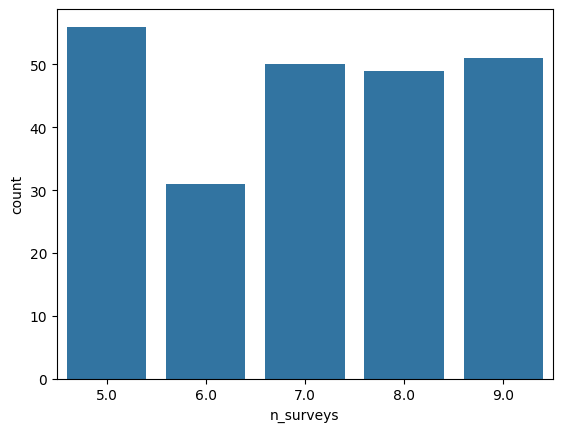

In [17]:
# note that these numbers are different from the ones in the preregistration document, because the
# numbers in the prereg were counted BEFORE any PPT specific exclusions, whereas the numbers here are AFTER those exclusions
df_n_surveys = pd.DataFrame(df_ptp['n_surveys'].value_counts()).reset_index()
df_n_surveys.columns = ['n_surveys','count']
sns.barplot(data=df_n_surveys, x='n_surveys',y='count')
plt.show()

In [18]:
# number of participants
len(df_ptp)

237

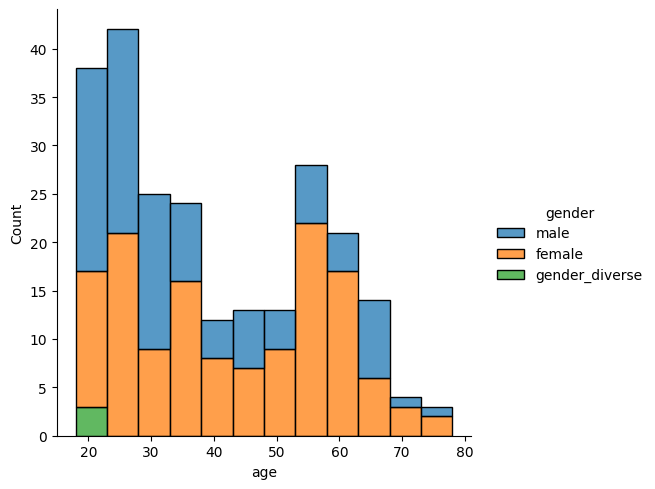

In [19]:
sns.displot(data=df_ptp, x='age', hue='gender', binwidth=5, multiple='stack')
plt.show()

In [20]:
min(df_ptp['age'])

18.0

In [21]:
max(df_ptp['age'])

78.0

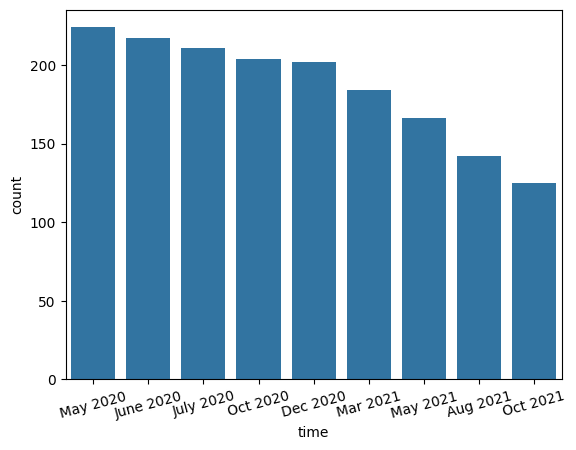

In [22]:
# the number of surveys completed at each round
df_attrition = pd.DataFrame(df_w['months_text'].value_counts()).reset_index()
df_attrition.columns = ['time','count']
sns.barplot(data=df_attrition, x='time',y='count')
plt.xticks(rotation=15)
plt.show()

### Order of presentation effect

In [23]:
df_w['PPT_Order'].value_counts()

,count
PPT_Order,
personal/collective,841
collective/personal,834


### Regional effect

In [24]:
countries = list(regions_dict.keys())
country_names_ECDC = {'New Zealand':'New_Zealand', 'United States Of America':'United_States_of_America',
                      'United Kingdom':'United_Kingdom'}
df_covid['country'] = df_covid['country'].replace(country_names_ECDC)
df_covid['region'] = df_covid['country'].map(regions_dict)
for i in range(len(countries)):
    if countries[i] in country_names_ECDC.keys():
        countries[i] = country_names_ECDC[countries[i]]

df_covid = df_covid[df_covid['country'].isin(countries)]
df_covid['year'], df_covid['week'], df_covid['weeks_since_2020'] = np.nan, np.nan, np.nan
for index, row in df_covid.iterrows():
    year = int(row['year_week'].split('-')[0])
    week = int(row['year_week'].split('-')[1])
    df_covid.at[index, 'year'] = year
    df_covid.at[index, 'week'] = week
    df_covid.at[index, 'weeks_since_2020'] = 53*(year-2020) + week
df_covid = df_covid[df_covid['year'] != 2022].reset_index(drop=True)

<ipython-input-24-8eb907311cee>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covid['year'], df_covid['week'], df_covid['weeks_since_2020'] = np.nan, np.nan, np.nan
<ipython-input-24-8eb907311cee>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covid['year'], df_covid['week'], df_covid['weeks_since_2020'] = np.nan, np.nan, np.nan
<ipython-input-24-8eb907311cee>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [25]:
df_ptp['region'].value_counts()

,count
region,
UK,101
EU,75
NA,52
SA,6
OC,3


In [26]:
fig = px.line(df_covid[df_covid['indicator']=='deaths'], x='weeks_since_2020', y='cumulative_count',
                 color='region', hover_data=['country'])
fig.show()

In [27]:
fig = px.line(df_covid[df_covid['indicator']=='deaths'], x='weeks_since_2020', y='rate_14_day',
                 color='region', hover_data=['country'])
fig.show()

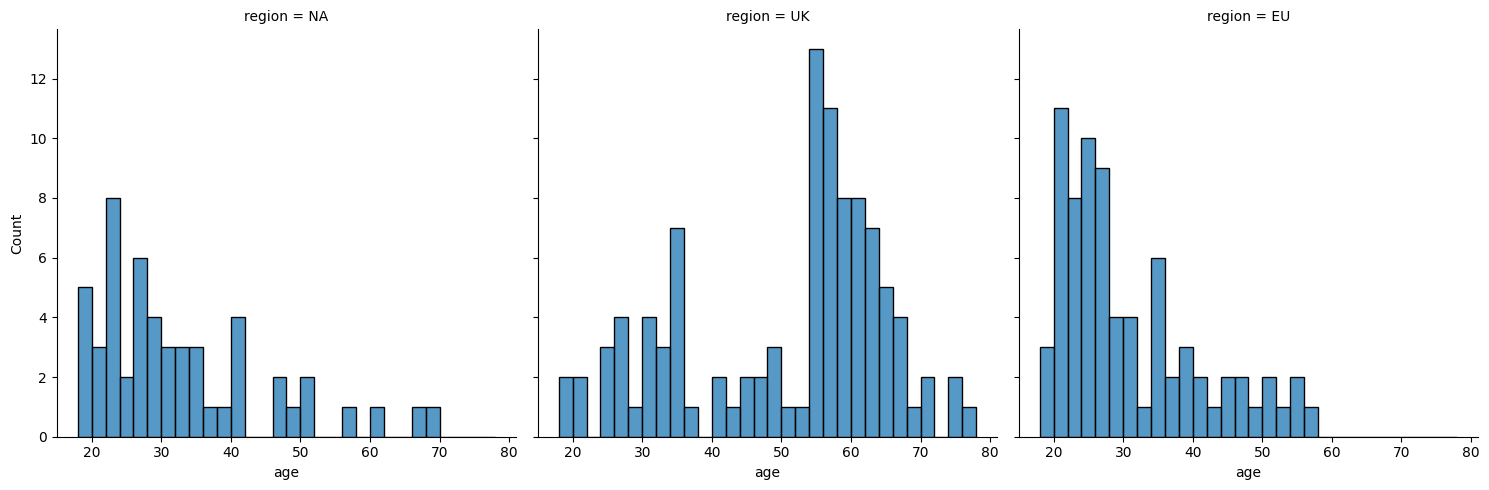

In [28]:
df_ptp_region = df_ptp[df_ptp['region'].isin(['UK','EU','NA'])].reset_index(drop=True)
sns.displot(data=df_ptp_region, x='age', col='region', binwidth=2)
plt.show()

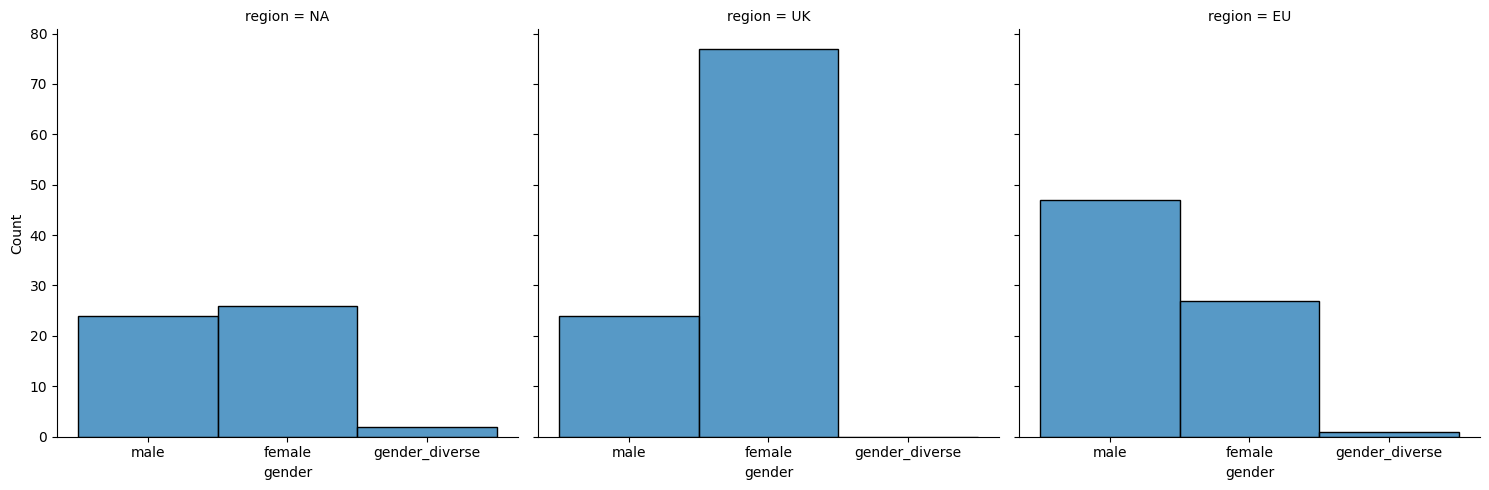

In [29]:
sns.displot(data=df_ptp_region, x='gender', col='region', binwidth=0.9)
plt.show()

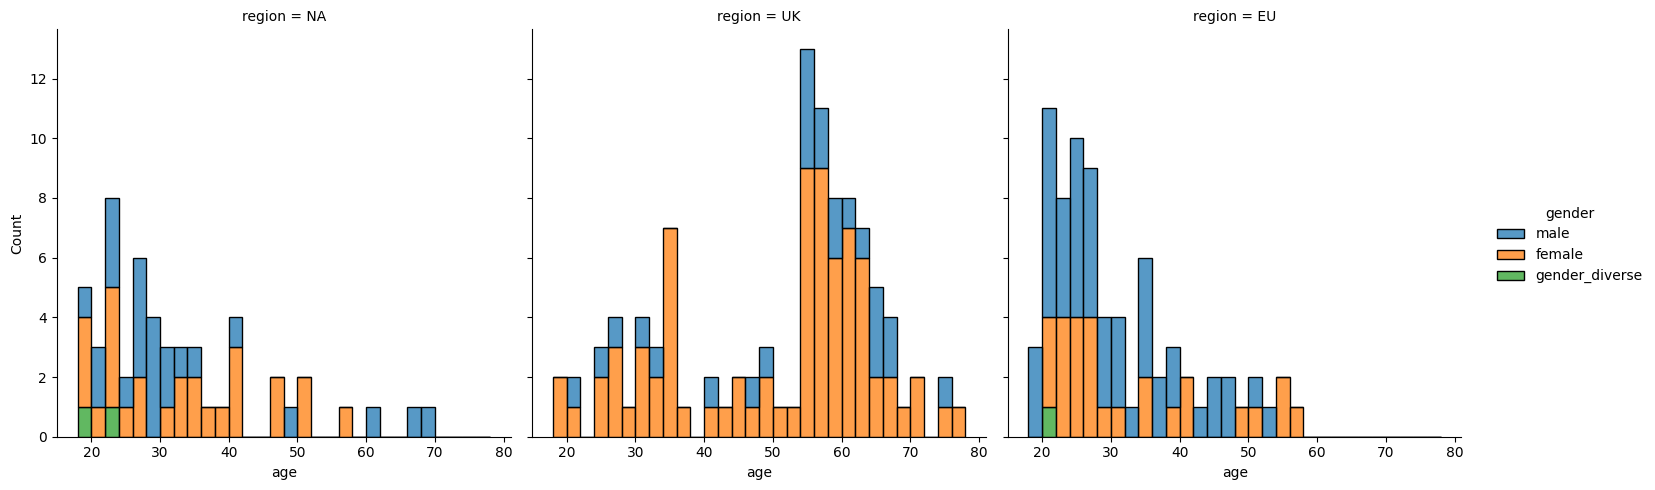

In [30]:
sns.displot(data=df_ptp_region, x='age', col='region', hue='gender', binwidth=2, multiple='stack')
plt.show()

### Narrative length

In [31]:
df['word_length'] = df['text'].apply(lambda x: len(tokenizer.tokenize(x)))

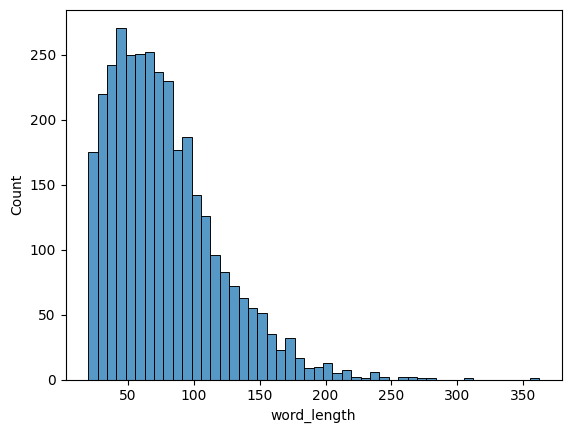

In [32]:
sns.histplot(data=df, x='word_length')
plt.show()

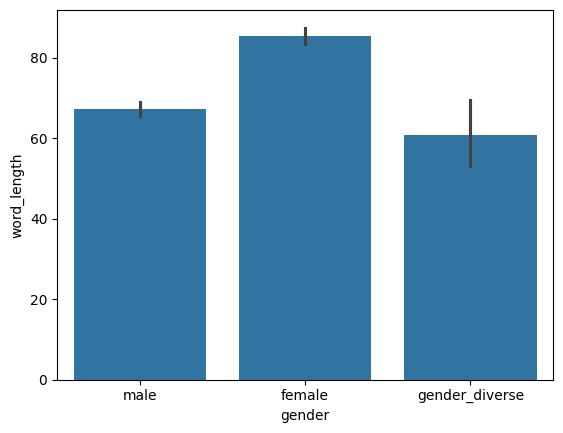

In [33]:
sns.barplot(data=df, x='gender', y='word_length')
plt.show()

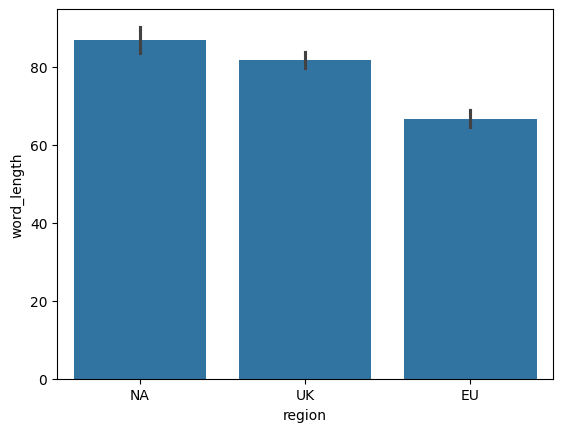

In [34]:
sns.barplot(data=df[df['region'].isin(['NA','UK','EU'])], x='region', y='word_length')
plt.show()

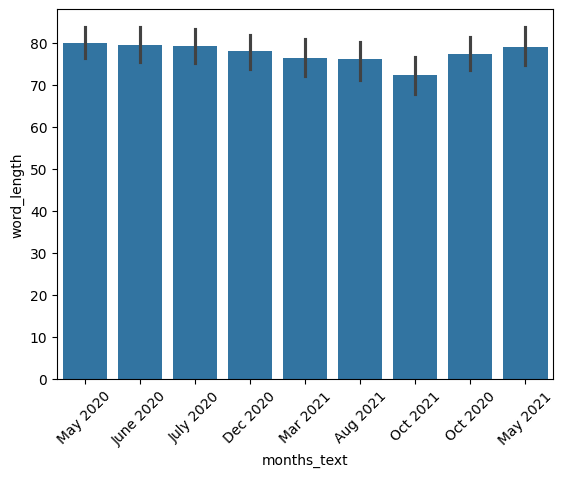

In [35]:
sns.barplot(data=df, x='months_text', y='word_length')
plt.xticks(rotation = 45)
plt.show()

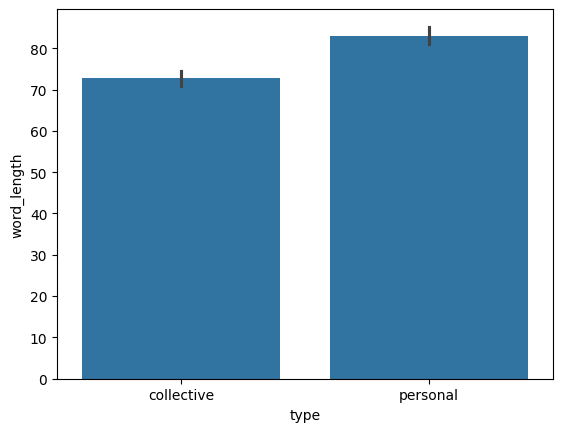

In [36]:
sns.barplot(data=df, x='type', y='word_length')
plt.show()

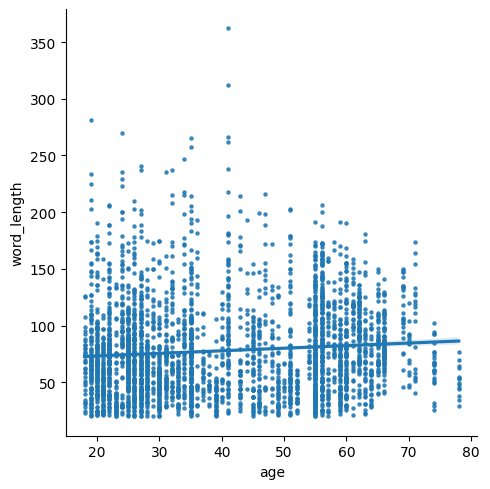

In [37]:
sns.lmplot(data=df, x='age', y='word_length', scatter_kws={"s": 5})
plt.show()

In [38]:
%%R -i df
age_length_model <- df %>%
  lmer(word_length ~ (1|ptp) + age, na.action = "na.exclude", data = .)
summary(age_length_model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: word_length ~ (1 | ptp) + age
   Data: .

REML criterion at convergence: 32232.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3497 -0.5844 -0.0950  0.5116  6.5301 

Random effects:
 Groups   Name        Variance Std.Dev.
 ptp      (Intercept) 999.6    31.62   
 Residual             714.0    26.72   
Number of obs: 3350, groups:  ptp, 238

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  68.4283     5.6439 235.9771  12.124   <2e-16 ***
age           0.2102     0.1317 235.2053   1.596    0.112    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
age -0.928


# Question 1: Does the topical content of people’s personal and collective narratives differ?
**Hypothesis 1**: We expect personal narratives to contain more self-related topics, and collective narratives to contain more public-related topics. <br>
**Analysis 1**: We will run STM on the entire corpus to identify the most prevalent topics, and then conduct regression (stm package in R; Roberts et al., 2019) on the frequencies of these topics in each narrative, with narrative type as the predictor.

In [39]:
%%R -i df
#### preprocess documents ####
# select relevant columns
df <- select(df, c('ptp','months','months_baseline','type','text'))
# convert months to factors from numbers
df$months_baseline <- factor(df$months_baseline, levels=c(0,1,2,5,7,10,12,15,17))
# preprocess text
processed <- textProcessor(documents = df$text, metadata = df, verbose=TRUE)
# set the lower threshold to 2, because the input data is already spell-checked.
# the removed words are not meaningless, but by definition stm is based on a
# distribution of words in documents, and would not work if there's only one
# instance
out <- prepDocuments(documents = processed$documents,
                          vocab = processed$vocab, meta = processed$meta,
                          lower.thresh = 2)

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 2501 of 5117 terms (3151 of 112562 tokens) due to frequency 
Your corpus now has 3350 documents, 2616 terms and 109411 tokens.

Structural Topic Modeling requires a predetermined number of topics, denoted as K. To determine K in a data-driven way, we first narrowed down the search space to K values between 15 and 25, based on the common number of topics observed in similar corpora. We then aimed to balance semantic coherence and exclusivity for each K. Semantic coherence measures the similarity of meaning within a topic, while exclusivity measures the distinction of meaning between topics.

In [40]:
%%R
storage <- searchK(out$documents, out$vocab, K = seq(15,25,by=1),
                   prevalence =~ type * s(months), data = out$meta,
                   heldout.seed = 1234)

Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Finding anchor words...
 	...............
	 Recovering initialization...
 	..........................
Initialization complete.
.....................................................................................................
Completed E-Step (2 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -6.556) 
.....................................................................................................
Completed E-Step (1 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -6.347, relative change = 3.179e-02) 
.....................................................................................................
Completed E-Step (1 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -6.308, relative change = 6.163e-03) 
.....................................................................................................
Completed E-S

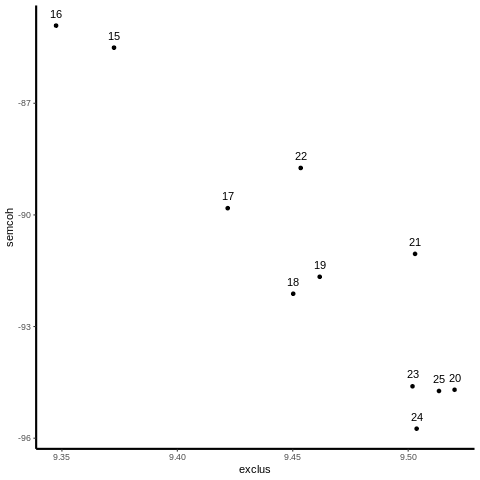

In [41]:
%%R
df_searchK <- as_tibble(storage$results)
df_searchK$K <- as.numeric(df_searchK$K)
df_searchK$exclus <- as.numeric(df_searchK$exclus)
df_searchK$semcoh <- as.numeric(df_searchK$semcoh)
K <- 21
ggplot(df_searchK, aes(x=exclus, y=semcoh)) +
  geom_point() +
  geom_text(aes(label=K), vjust = -1, check_overlap = TRUE) +
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        axis.line = element_line(color='black',linewidth = 1))

As shown in the plot, the highest values for semantic coherence (semcoh) and exclusivity (exclus) were achieved with K values of 21 and 22. While both values indicated good topic model performance, after observing the generated topics and considering interpretability, we ultimately selected **K = 21** for our analysis.

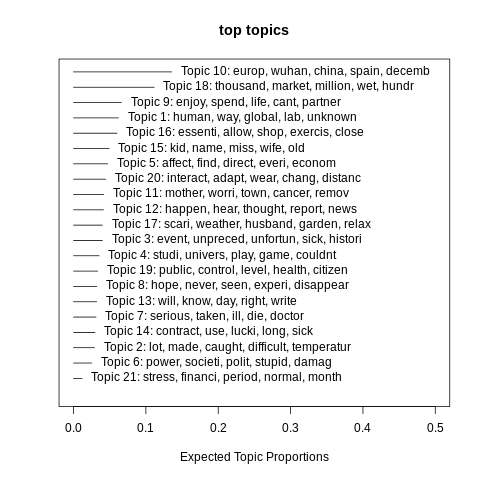

In [42]:
%%R
fit <- stm(documents = out$documents, vocab = out$vocab, K = K,
           prevalence =~ type * s(months),
           data = out$meta, init.type = "Spectral", verbose=FALSE)
prep <- estimateEffect(1:K ~ type * s(months), fit,
                       meta = out$meta, uncertainty = "Global")
topic_prop_matrix <- fit$theta
topic_prop_df <- as.data.frame(topic_prop_matrix)
metadata <- processed$meta
metadata$months_text <- recode(metadata$months,`5.5`='May2020',`6.5`='Jun2020',`7.5`='Jul2020',`10.5`='Oct2020',`12.5`='Dec2020',`15.5`='Mar2021',`17.5`='May2021',`20.5`='Aug2021',`22.5`='Oct2021')
topic_prop_df <- cbind(metadata, topic_prop_df)
plot(fit, type = "summary", labeltype='frex', xlim = c(0, 0.5), n=5,
     main='top topics')

We named the topics using ChatGPT. The top 6 topics, which were significantly more prevalent in collective narratives, were termed 'public topics.' The bottom 6 topics, which were significantly more prevalent in autobiographical narratives, were termed 'personal topics.'

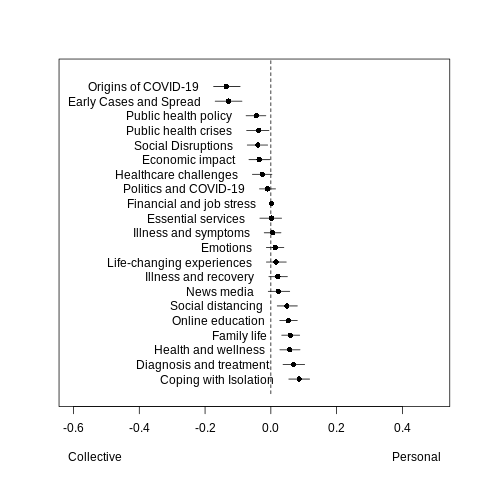

In [43]:
%%R
type_diff <- plot(prep, covariate = "type", method = "difference", model = fit,
     cov.value1 = "personal", cov.value2 = "collective",
     labeltype = "custom", verbose.labels = FALSE, n = 3,
     xlab = "Collective                                                                                          Personal",
     topics=c(18,10,19,3,1,5,7,6,21,16,2,13,8,14,12,20,4,15,17,11,9),
     custom.labels=c('Origins of COVID-19','Early Cases and Spread',
                     'Public health policy','Public health crises',
                     'Social Disruptions','Economic impact',
                     'Healthcare challenges','Politics and COVID-19',
                     'Financial and job stress','Essential services',
                     'Illness and symptoms','Emotions',
                     'Life-changing experiences','Illness and recovery',
                     'News media','Social distancing','Online education',
                     'Family life','Health and wellness',
                     'Diagnosis and treatment','Coping with Isolation'),
     xlim = c(-.6, .5))

boundary (singular) fit: see help('isSingular')


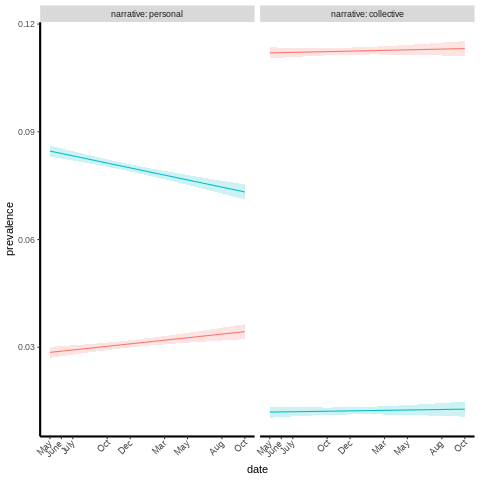

In [44]:
%%R
collective_topics <- c('V1','V3','V5','V10','V18','V19')
personal_topics <- c('V4','V9','V11','V15','V17','V20')
# calculate the average collective and personal topic prevalence
topic_prop_df$collective_prop <- rowMeans(
  subset(topic_prop_df, select = collective_topics))
topic_prop_df$personal_prop <- rowMeans(
  subset(topic_prop_df, select = personal_topics))
# construct df with just collective and personal topic proportions in long format
topic_integrat_df <- topic_prop_df %>%
  select(ptp, months_baseline, type, collective_prop, personal_prop) %>%
  rename(narrative = type) %>%
  pivot_longer(c(collective_prop, personal_prop), names_to='topic', values_to='prevalence') %>%
  mutate(topic = recode(topic, 'collective_prop' = 'collective', 'personal_prop' = 'personal'))
# plot
topic_integrat_df$narrative <- factor(topic_integrat_df$narrative, levels = c("personal","collective"))
topic_integrat_df$topic <- factor(topic_integrat_df$topic, levels = c("collective","personal"))
topic_integrat_df$months_baseline <- as.integer(as.character(topic_integrat_df$months_baseline))
topic_integrat_fit <- lmer(
  prevalence ~ months_baseline*topic*narrative + (1+months_baseline|ptp), data=topic_integrat_df)
topic_integrat_fit_simple <- lm(
  prevalence ~ months_baseline*topic*narrative, data=topic_integrat_df)
ggpredict <- ggPredict(topic_integrat_fit_simple,se=TRUE, point=FALSE)
plot(ggpredict) +
  # theme_bw() +
  scale_x_continuous(name="date",
                     breaks=c(0,1,2,5,7,10,12,15,17),
                     labels=c('May','June','July','Oct','Dec','Mar','May','Aug','Oct')) +
  theme(axis.text.x = element_text(angle = 45, vjust = 1.3, hjust=1.3),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        axis.line = element_line(color='black',linewidth = 1),
        legend.position = "none")

In [45]:
%%R
anova(topic_integrat_fit)

Type III Analysis of Variance Table with Satterthwaite's method
                                Sum Sq Mean Sq NumDF  DenDF   F value    Pr(>F)
months_baseline                 0.0002  0.0002     1 2703.1    0.1475 0.7009999
topic                           0.3332  0.3332     1 6467.8  207.5259 < 2.2e-16
narrative                       0.0198  0.0198     1 6467.8   12.3038 0.0004551
months_baseline:topic           0.0139  0.0139     1 6467.8    8.6376 0.0033045
months_baseline:narrative       0.0026  0.0026     1 6467.8    1.6395 0.2004396
topic:narrative                 4.2015  4.2015     1 6467.8 2616.7110 < 2.2e-16
months_baseline:topic:narrative 0.0127  0.0127     1 6467.8    7.9059 0.0049423
                                   
months_baseline                    
topic                           ***
narrative                       ***
months_baseline:topic           ** 
months_baseline:narrative          
topic:narrative                 ***
months_baseline:topic:narrative ** 
---
Sign

In [46]:
%%R
emtrends(topic_integrat_fit, ~ topic * narrative, var='months_baseline')

 topic      narrative  months_baseline.trend       SE  df asymp.LCL asymp.UCL
 collective personal                3.58e-04 0.000177 Inf  1.17e-05  0.000704
 personal   personal               -6.52e-04 0.000177 Inf -9.98e-04 -0.000306
 collective collective              8.90e-05 0.000177 Inf -2.57e-04  0.000435
 personal   collective              6.67e-05 0.000177 Inf -2.80e-04  0.000413

Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 6700' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 6700)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 6700' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 6700)' or larger];
but be warned that this may result in large computation time and memory use.


In [47]:
%%R
pairs(emtrends(topic_integrat_fit, ~ topic | narrative, var='months_baseline'))

narrative = personal:
 contrast              estimate       SE  df z.ratio p.value
 collective - personal 1.01e-03 0.000248 Inf   4.066  <.0001

narrative = collective:
 contrast              estimate       SE  df z.ratio p.value
 collective - personal 2.23e-05 0.000248 Inf   0.090  0.9283

Degrees-of-freedom method: asymptotic 


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 6700' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 6700)' or larger];
but be warned that this may result in large computation time and memory use.
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 6700' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 6700)' or larger];
but be warned that this may result in large computation time and memory use.


In [48]:
%%R
df_time <- data.frame()
labels_ordered_by_topic_number <-
  c('C1: Social Disruptions','N2: Illness and symptoms',
    'C3: Public health crises','A4: Online education',
    'C5: Economic impact','N6: Politics and COVID-19',
    'N7: Healthcare challenges','N8: Life-changing experiences',
    'A9: Coping with Isolation','C10: Early Cases and Spread',
    'A11: Diagnosis and treatment','N12: News media',
    'N13: Emotions','N14: Illness and recovery',
    'A15: Family life','N16: Essential services',
    'A17: Health and wellness','C18: Origins of COVID-19',
    'C19: Public health policy','A20: Social distancing',
    'N21: Financial and job stress')

for (t in seq(K)){
  type_diff_c <- plot(prep, covariate = "months",
                      moderator = "type", moderator.value = "collective",
                      method = "pointestimate", model = fit,
                      topics=c(t), omit.plot=TRUE)
  type_diff_p <- plot(prep, covariate = "months",
                      moderator = "type", moderator.value = "personal",
                      method = "pointestimate", model = fit,
                      topics=c(t), omit.plot=TRUE)
  df_ci_c <- as.data.frame(t(type_diff_c$cis[[1]]))
  df_ci_p <- as.data.frame(t(type_diff_p$cis[[1]]))
  df_time_topic <- as.data.frame(type_diff_c$uvals)
  colnames(df_time_topic) <- 'label'
  df_time_topic$mean_c <- type_diff_c$means[[1]]
  df_time_topic$mean_p <- type_diff_p$means[[1]]
  df_time_topic$lower_c <- df_ci_c$`2.5%`
  df_time_topic$upper_c <- df_ci_c$`97.5%`
  df_time_topic$lower_p <- df_ci_p$`2.5%`
  df_time_topic$upper_p <- df_ci_p$`97.5%`
  df_time_topic$topic <- rep(t, 9)
  df_time <- rbind(df_time, df_time_topic)
}

df_time$topic_type = c(
  rep('public',9),rep('neutral',9),rep('public',9),rep('personal',9),rep('public',9),
  rep('neutral',9),rep('neutral',9),rep('neutral',9),rep('personal',9),rep('public',9),
  rep('personal',9),rep('neutral',9),rep('neutral',9),rep('neutral',9),rep('personal',9),
  rep('neutral',9),rep('personal',9),rep('public',9),rep('public',9),rep('personal',9),rep('neutral',9)
)
df_time$topic_type <- factor(df_time$topic_type, levels=c('public','neutral','personal'))

df_time_topic_type <- df_time %>%
  group_by(topic_type, label) %>%
  summarise(group_mean_c=mean(mean_c), group_mean_p=mean(mean_p)) %>%
  filter(topic_type!='neutral')


`summarise()` has grouped output by 'topic_type'. You can override using the
`.groups` argument.


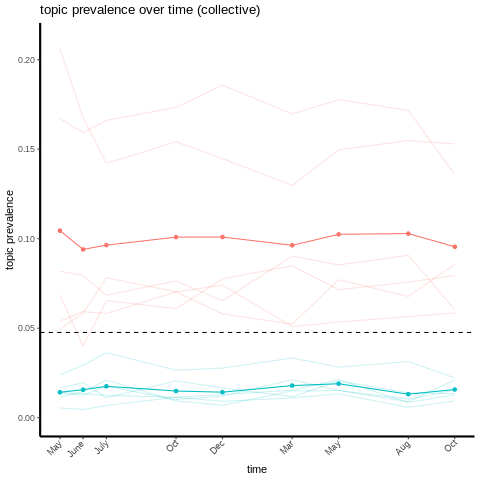

In [49]:
%%R
ggplot(filter(df_time, topic_type!='neutral'))+
  geom_line(aes(x=label,y=mean_c,group=topic,color=topic_type),alpha=0.2)+
  geom_point(data=df_time_topic_type,aes(x=label,y=group_mean_c,color=topic_type))+
  geom_line(data=df_time_topic_type,aes(x=label,y=group_mean_c,color=topic_type))+
  geom_hline(yintercept = 1/21, color='black', linetype='dashed') +
  scale_x_continuous(breaks=c(5.5,6.5,7.5,10.5,12.5,15.5,17.5,20.5,22.5),
                     labels=c('May','June','July','Oct','Dec','Mar','May','Aug','Oct'))+
  coord_cartesian(ylim=c(0,0.21))+
  labs(x='time',y='topic prevalence',
       title='topic prevalence over time (collective)')+
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        axis.line = element_line(color='black',linewidth = 1),
        axis.text.x = element_text(angle = 45, vjust = 1.3, hjust=1.3),
        legend.position = "none")

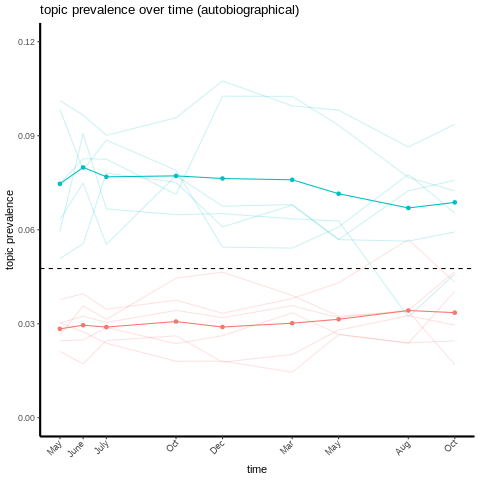

In [50]:
%%R
ggplot(filter(df_time, topic_type!='neutral'))+
  geom_line(aes(x=label,y=mean_p,group=topic,color=topic_type),alpha=0.2)+
  geom_point(data=df_time_topic_type,aes(x=label,y=group_mean_p,color=topic_type))+
  geom_line(data=df_time_topic_type,aes(x=label,y=group_mean_p,color=topic_type))+
  geom_hline(yintercept = 1/21, color='black', linetype='dashed') +
  scale_x_continuous(breaks=c(5.5,6.5,7.5,10.5,12.5,15.5,17.5,20.5,22.5),
                     labels=c('May','June','July','Oct','Dec','Mar','May','Aug','Oct'))+
  scale_y_continuous(breaks=c(0,0.03,0.06,0.09,0.12),labels=c('0.00',0.03,0.06,0.09,0.12)) +
  coord_cartesian(ylim=c(0,0.12))+
  labs(x='time',y='topic prevalence',
       title='topic prevalence over time (autobiographical)')+
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        axis.line = element_line(color='black',linewidth = 1),
        axis.text.x = element_text(angle = 45, vjust = 1.3, hjust=1.3),
        legend.position = "none")

blah blah

# Question 2: Over time, does a collective pandemic narrative emerge while personal pandemic narratives become more idiosyncratic?
**Hypothesis 2a**: Inter-personal (between-subjects) similarity will be higher for collective than personal narratives. <br>
**Hypothesis 2b**: Inter-personal similarity of collective narratives will increase over time, while that of personal narratives may decrease over time. <br>
**Analysis 2ab**: Using pairwise cosine inter-personal similarity (calculated across participants within the narrative type and timepoint), we will construct a crossed random effects model, with narrative type and time as the fixed effects, and pairs of participants being compared with each other as the crossed random effects. We will calculate the main effect of narrative type to test hypothesis 2a, and its interaction with time to test hypothesis 2b.

**Hypothesis 2c**: Inter-personal similarity metrics for participants belonging to the same “community” (as measured by participants’ shared geographical region, shared COVID-19 experiences, or both) will be higher overall and increase more rapidly over time than for participants in different communities.<br>
**Analysis 2c**: We will re-compute Analysis 2ab, nesting participants according to community and testing the importance of shared communities using permutation testing. Additionally, we will compute the pairwise similarities between narratives generated by participants in the same vs. different geographical regions.

# Question 3: Do an individual’s representations of their personal and collective narratives become more similar over time?
**Hypothesis 3**: Intra-personal (within-subject) similarity of personal and collective narratives will increase over time. <br>
**Analysis 3**: Using pairwise cosine intra-personal similarity (calculated across narrative time but within participants and within timepoint), we will construct a linear mixed effects model, with time as the fixed effect, and participant as the random effect.

**Note**<br>
1. USE acc drop off with longer text (look for citation), use this to justify the start, mid, end separation
1. We have 9 measurements per group (i.e. participant), so we can have 8 random coefficients at most. Some participants have done only 5 measurements, but it's ok because that's considered missing data and can be filled with LME

In [51]:
#### Calculate within-subject similarity of personal and collective narratives
df3 = df_w.copy()
df3['sim'] = np.nan
df3['sim_start'] = np.nan
df3['sim_mid'] = np.nan
df3['sim_end'] = np.nan
for index, row in df3.iterrows():
    similarity = USE_similarity(USE, row['collective'], row['personal'])
    sim_start, sim_mid, sim_end = USE_similarity_portion(USE, row['collective'], row['personal'])
    df3.at[index, 'sim'] = similarity
    df3.at[index, 'sim_start'] = sim_start
    df3.at[index, 'sim_mid'] = sim_mid
    df3.at[index, 'sim_end'] = sim_end
df3.head()
df3.to_excel('USE_withinsubject_withintime.xlsx')

In [52]:
df3_l = df3.melt(id_vars=['ptp','age','gender','Sn','days','months','months_text','months_baseline','region','sim'],
                 value_vars=['sim_start','sim_mid','sim_end'], var_name='portion',value_name='sim_portion')
df3_l.head()

,ptp,age,gender,Sn,days,months,months_text,months_baseline,region,sim,portion,sim_portion
0,13,60.0,male,0,127.0,5.5,May 2020,0.0,NA,0.209472,sim_start,0.111469
1,13,60.0,male,2,170.0,6.5,June 2020,1.0,NA,0.369730,sim_start,0.228624
2,13,60.0,male,3,201.0,7.5,July 2020,2.0,NA,0.362157,sim_start,0.138863
3,13,60.0,male,5,351.0,12.5,Dec 2020,7.0,NA,0.313278,sim_start,0.130180
4,13,60.0,male,6,444.0,15.5,Mar 2021,10.0,NA,0.323286,sim_start,0.022759


we could also run a supplimentary model with survey number as an ordinal variable

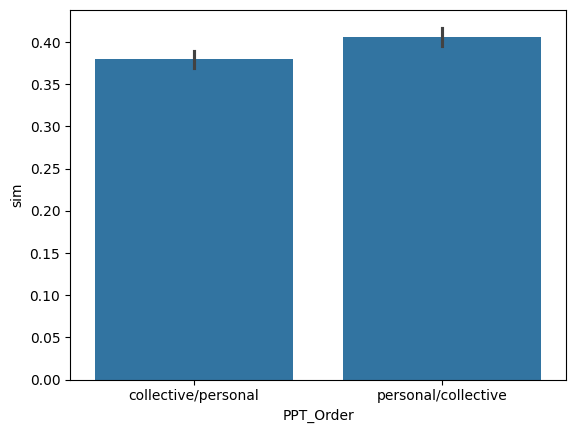

In [53]:
sns.barplot(data=df3, x='PPT_Order', y='sim')
plt.show()

In [54]:
%%R -i df3
df3_order_test <- df3 %>%
  pivot_wider(names_from=PPT_Order, values_from=sim)
print(t.test(df3_order_test$`collective/personal`, df3_order_test$`personal/collective`))


	Welch Two Sample t-test

data:  df3_order_test$`collective/personal` and df3_order_test$`personal/collective`
t = -3.7234, df = 1660.8, p-value = 0.0002031
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04121538 -0.01277463
sample estimates:
mean of x mean of y 
0.3794308 0.4064258 



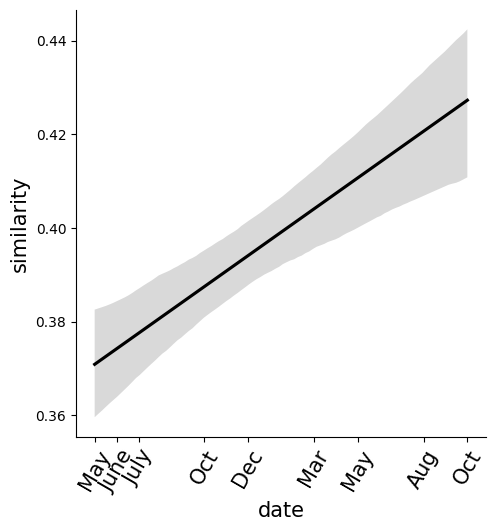

In [56]:
#### Plot the change of within-subject similarity of personal and collective narratives over time
# plot days as the number of days since Jan 1, 2020
fontsize=15
sns.lmplot(data=df3, x='months', y='sim', scatter_kws={"s": 5,"alpha": 0.1,'color':'black'}, line_kws={'color':'black'}, scatter=False)
plt.ylabel('similarity', fontsize=fontsize)
plt.xlabel('date', fontsize=fontsize)
plt.xticks([5.5,6.5,7.5,10.5,12.5,15.5,17.5,20.5,22.5], ['May','June','July','Oct','Dec','Mar','May','Aug','Oct'], rotation=60, fontsize=fontsize)
plt.show()

In [58]:
%%R -i df3
df3 <- df3 %>%
  # convert ptp to factor
  mutate(across(all_of(c('ptp')), factor)) %>%
  group_by(ptp) %>%
  # mean centre similarity
  # this allows the model to converge, and also makes conceptual sense because we care about the progression of similarities over time, not the baseline individual difference
  mutate(sim = sim - mean(sim, na.rm = TRUE)) %>%
  ungroup()

model3 <- df3 %>%
  lmer(sim ~ (1+months_baseline|ptp) + months_baseline, na.action = "na.exclude", data = .)
print(summary(model3))
# print('R2: showing the amount of variance that the current model explains')
# print(semipartial_R2(model3))
# print('ICC: how dependent observations within a group are on each other, random effects should be modeled if ICC > 0.1')
# print(calculate_icc_lmer(model3))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: sim ~ (1 + months_baseline | ptp) + months_baseline
   Data: .

REML criterion at convergence: -2538.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4601 -0.6205  0.0044  0.5875  3.9943 

Random effects:
 Groups   Name            Variance  Std.Dev. Corr 
 ptp      (Intercept)     9.615e-04 0.031008      
          months_baseline 2.162e-05 0.004649 -1.00
 Residual                 1.213e-02 0.110148      
Number of obs: 1675, groups:  ptp, 238

Fixed effects:
                  Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)     -1.954e-02  4.666e-03  3.982e+02  -4.189 3.45e-05 ***
months_baseline  2.915e-03  5.775e-04  2.150e+02   5.047 9.56e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
months_bsln -0.813
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see he

boundary (singular) fit: see help('isSingular')


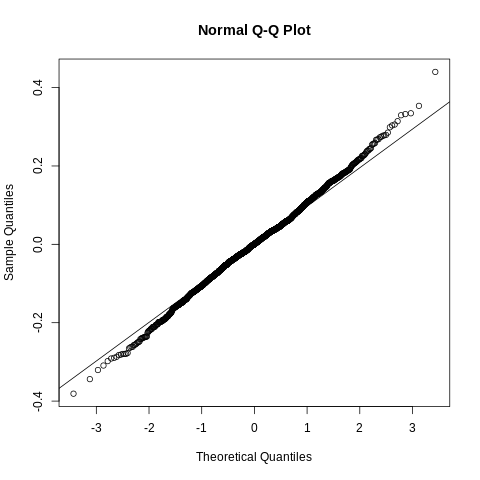

In [59]:
%%R
qqnorm(resid(model3))
qqline(resid(model3))
# look for some threshold to determine normality

In [60]:
%%R
# calculate the confidence interval of the main effect using bootstrapping
boot_function = function(data, indices) {
  boot_model = data[indices,] %>%
    lmer(sim ~ (1+months_baseline|ptp) + months_baseline, na.action = "na.exclude", data = .)
  return(boot_model %>% fixef)
}
set.seed(2022)
bootstrapped_model = df3 %>% boot(statistic=boot_function, R=50)
print(bootstrapped_model$t0)
print(bootstrapped_model %>% boot.ci(index = 2, type = "perc"))

    (Intercept) months_baseline 
   -0.019544686     0.002914592 
BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 50 bootstrap replicates

CALL : 
boot.ci(boot.out = ., type = "perc", index = 2)

Intervals : 
Level     Percentile     
95%   ( 0.0018,  0.0040 )  
Calculations and Intervals on Original Scale
Some percentile intervals may be unstable


boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSingular')
boundary (singular) fit: see help('isSin

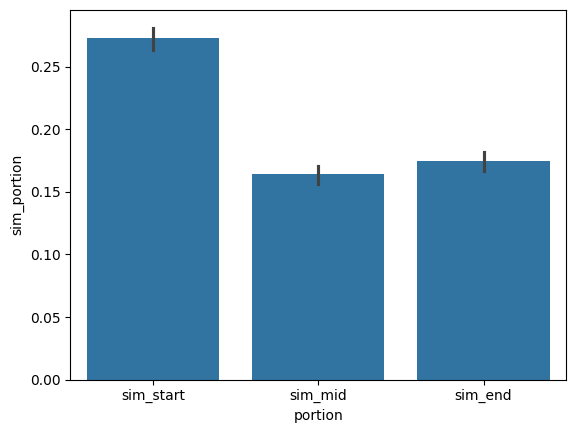

In [61]:
sns.barplot(data=df3_l, x='portion',y='sim_portion')
plt.show()

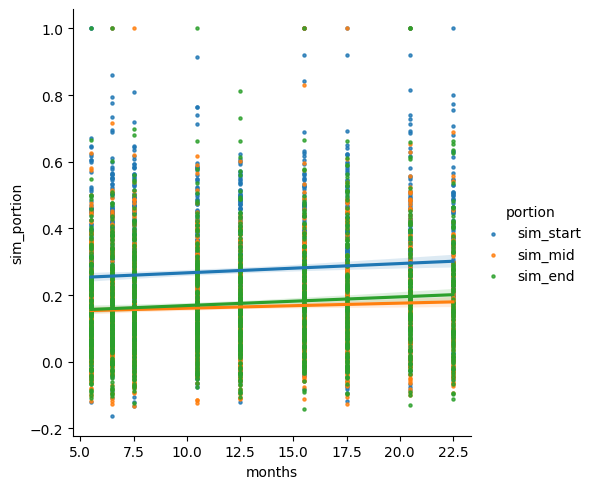

In [62]:
sns.lmplot(data=df3_l, x='months', y='sim_portion', hue='portion', scatter_kws={"s": 5})
plt.show()

In [64]:
%%R -i df3_l
df3_l <- df3_l %>%
  # convert ptp to factor
  mutate(across(all_of(c('ptp')), factor)) %>%
  group_by(ptp) %>%
  # mean centre similarity
  # this allows the model to converge, and also makes conceptual sense because we care about the progression of similarities over time, not the baseline individual difference
  mutate(sim_portion = sim_portion - mean(sim_portion, na.rm = TRUE)) %>%
  ungroup()

model3b <- df3_l %>%
  lmer(sim_portion ~ (1+months_baseline|ptp) + portion * months_baseline, na.action = "na.exclude", data = .)
print(summary(model3b))
# print('R2: showing the amount of variance that the current model explains')
# print(semipartial_R2(model3b))
# print('ICC: how dependent observations within a group are on each other, random effects should be modeled if ICC > 0.1')
# print(calculate_icc_lmer(model3b))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: sim_portion ~ (1 + months_baseline | ptp) + portion * months_baseline
   Data: .

REML criterion at convergence: -4593.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7171 -0.6626 -0.0805  0.5665  6.0490 

Random effects:
 Groups   Name            Variance  Std.Dev. Corr 
 ptp      (Intercept)     0.0006782 0.026042      
          months_baseline 0.0000152 0.003898 -1.00
 Residual                 0.0228045 0.151012      
Number of obs: 5025, groups:  ptp, 238

Fixed effects:
                                   Estimate Std. Error         df t value
(Intercept)                      -4.484e-02  6.000e-03  1.996e+03  -7.473
portionsim_mid                   -3.241e-03  8.130e-03  4.790e+03  -0.399
portionsim_start                  9.734e-02  8.130e-03  4.790e+03  11.972
months_baseline                   2.286e-03  7.130e-04  1.074e+03   3.206
portionsim_mid:months_baseline   -1.

boundary (singular) fit: see help('isSingular')


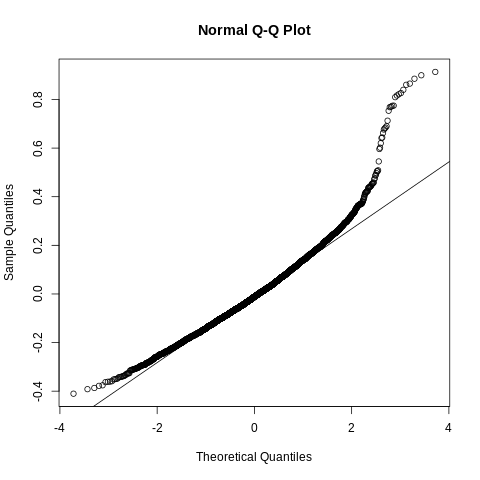

In [65]:
%%R
qqnorm(resid(model3b))
qqline(resid(model3b))
# normality paper: lingering paper (Buddhika, 2022)
# maybe use non-normal parametric tests

In [66]:
USE_array = np.zeros((len(df), 512))
for index, row in df.iterrows():
    text = row['text']
    USE_vector = np.array(USE([text]))
    USE_array[index,:] = USE_vector

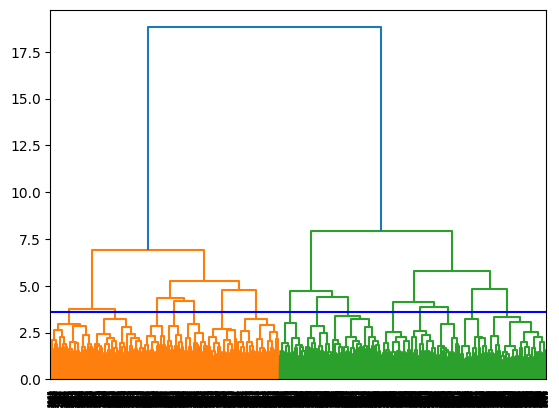

In [67]:
from scipy.cluster.hierarchy import dendrogram, linkage
linkage_data = linkage(USE_array, method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.axhline(y=3.6, color='blue', linestyle='-')
plt.show()
# 15 clusters

In [68]:
kmeans = KMeans(n_clusters=15).fit(USE_array)
kmeans_cluster = list(kmeans.labels_)
df['kmeans'] = kmeans_cluster

In [75]:
pca = PCA(n_components=50)
tsne = TSNE(n_components=2, verbose=0, perplexity=40, max_iter=300)
pca_result = pca.fit_transform(USE_array)
pca_tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
pca_tsne_results = tsne.fit_transform(pca_result)
df['pca-tsne1'] = pca_tsne_results[:,0]
df['pca-tsne2'] = pca_tsne_results[:,1]

In [76]:
def plot_USE(df, hue_type):
    df['kmeans'] = df['kmeans'].astype("string")
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(10,5))
    x = f'pca-tsne1'
    y = f'pca-tsne2'
    Sn_list = [0,2,3,4,5,6,7,8,9]
    for i in range(9):
        axes_x = i // 5
        axes_y = i % 5
        Sn = Sn_list[i]
        df_sub = df[df['Sn'] == Sn]
        sns.scatterplot(ax=axes[axes_x, axes_y],x=x, y=y,hue=hue_type,data=df_sub,legend=False,alpha=0.3,size=0.1)
        axes[axes_x, axes_y].set_title(f'S{Sn}')
        axes[axes_x, axes_y].set_xlim(-10,10)
        axes[axes_x, axes_y].set_ylim(-15,15)
        axes[axes_x, axes_y].axis('off')
    axes[1,4].axis('off')
    plt.show()

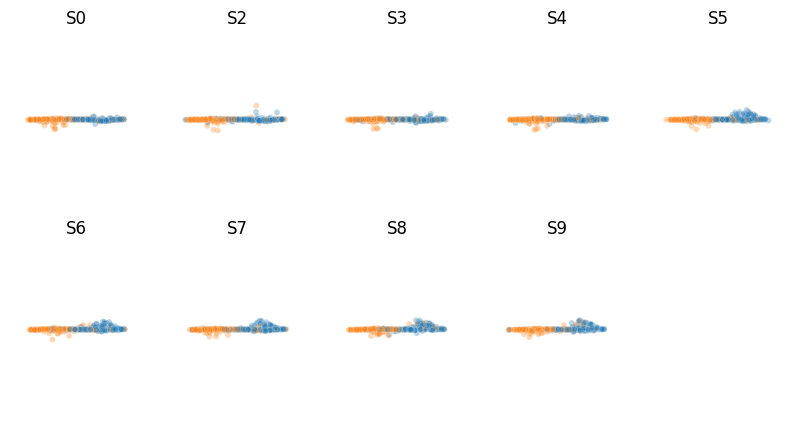

In [77]:
plot_USE(df, "type")

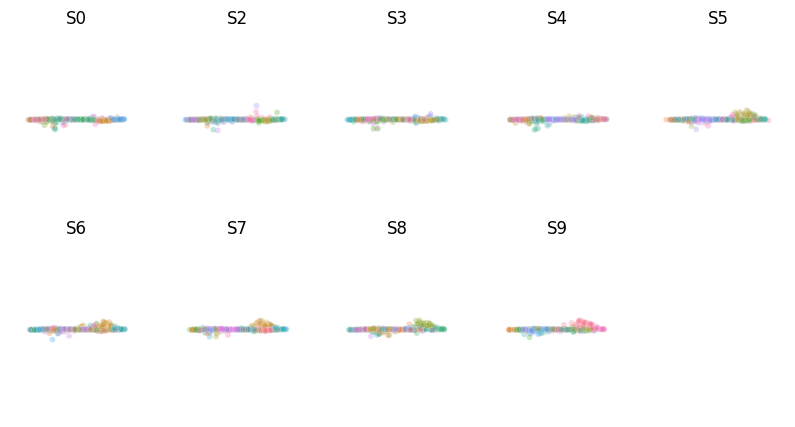

In [78]:
plot_USE(df, "kmeans")

In [73]:
df['kmeans'] = pd.to_numeric(df['kmeans'])
df.groupby(['type','kmeans']).count()['text'].unstack()

kmeans,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
type,,,,,,,,,,,,,,,
collective,152,239,13,209,9,3,14,194,92,19,212,189,306,12,12
personal,109,19,222,31,199,202,192,27,106,139,43,52,38,99,197


# Question 4: Does an individual’s narrative representation of the pandemic stabilize over time? Does this process differ for personal vs. collective narratives?
**Hypothesis 4a**: Intra-personal (within-subject) similarities between two temporally adjacent narratives (of the same type) will each increase over time (e.g., the similarity between personal narratives in March and May 2021 should be higher than for narratives in March and May 2020), reflecting the stabilization of the representation of the narrative.<br>
**Analysis 4a**: Using pairwise cosine intra-personal similarity (across adjacent time points but within participants and within narrative type), we will then construct a linear mixed effect model, with time and narrative type as the fixed effects, and participant as the random effect. Note that because intra-personal similarity is computed across adjacent time points but these similarity values are then compared over time, we will use the number of days for the earlier time point as the “time” variable in this model.

**Hypothesis 4b**: A set of “central” topics will emerge as a lifetime period narrative develops over time; that is, once included in a personal or collective narrative, these topics will always be included in the contents across all subsequent time points for that narrative type.<br>
**Analysis 4b**: We will run STM on the entire corpus to identify the most prevalent topics, and then conduct further non-linear regressions (stm package in R; Roberts et al., 2019) on the frequencies of these topics in each narrative, with time as a predictor. We will then repeat the analysis with personal and collective narratives separately.